# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test_temp'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "bert-base-cased",
}

# Dataset

I will use BERT

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer_embtest import SRLDataset_transformer_embtest

In [7]:
dataset_train_en = SRLDataset_transformer_embtest(  datasets_paths['EN']['train'], 
                                                    tokenizer = global_params['transformer_name'],
                                                    baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_es = SRLDataset_transformer_embtest(  datasets_paths['ES']['train'], 
                                                    tokenizer = dataset_train_en.tokenizer,
                                                    labels = dataset_train_en.labels)
dataset_train_fr = SRLDataset_transformer_embtest(  datasets_paths['FR']['train'], 
                                                    tokenizer = dataset_train_en.tokenizer,
                                                    labels = dataset_train_en.labels)

In [8]:
SRLDataset_transformer_embtest.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [9]:
dataset_dev_en = SRLDataset_transformer_embtest(datasets_paths['EN']['dev'], 
                                                tokenizer = dataset_train_en.tokenizer,
                                                labels = dataset_train_en.labels)

In [10]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [11]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates']),
    'n_dependency_relations_labels': len(dataset_train_en.labels['id_to_dependency_relations']),
    'n_pos_labels': len(dataset_train_en.labels['id_to_pos']),
})

Saving global variables...

In [12]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [15]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [16]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [17]:
for e in dataloader_dev_en:
    ex_in = e
    break

In [18]:
ex_in.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'roles', 'matrix_subwords', 'output_mask', 'predicates', 'predicate_position_raw', 'predicate_position', 'pos_tags', 'formatted_word_ids'])

In [19]:
print(ex_in['input_ids'][0], ex_in['input_ids'].shape)
print(ex_in['output_mask'][0], ex_in['output_mask'].shape)
print(ex_in['roles'][0], ex_in['roles'].shape)
print(ex_in['formatted_word_ids'][0], ex_in['formatted_word_ids'].shape)

tensor([  101,  1109,  2341, 18029,  1116,  1115,  1103,  1426,  1710,  2653,
         1167,  2209,  1106, 14516,  2316, 17030,  6185,  1103,  1484,  1104,
         1103,  1644,  7742,  6421,   117,  2699,  1105,  4223,  2088,  1164,
         1769,  2266,   119,   102, 18029,  1116,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]) torch.Size([32, 80])
tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) torch.Size([32, 80])
tensor([-1,  0,  1,  0, -1, 11,  0,  0,  0,  0,  0,  0,  0, 

In [20]:
print(ex_in['predicates'][0], ex_in['predicates'].shape)
print(ex_in['predicate_position'][0], ex_in['predicate_position'].shape)

tensor([ -1,   0,   0, 162,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         -1,  -1,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]) torch.Size([32, 80])
tensor(3) torch.Size([32])


In [21]:
torch.set_printoptions(edgeitems=80)
print(ex_in['matrix_subwords'].shape,'\n' , ex_in['matrix_subwords'][0][0:6,:10]) # word_ids[0:6] = [None, 0, 1, 2, 2, 3]
torch.set_printoptions(edgeitems=3)

torch.Size([32, 80, 80]) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


# Printing model

In [22]:
from torchinfo import summary

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

import matplotlib.pyplot as plt

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    for name, hist in dict_history.items():
        plt.plot([i for i in range(len(hist))], hist, label=name)
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

In [23]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

# Training the model with matrix computation

In [24]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_embtest import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer = True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
print_summary(final_model.model)

Net_aic_transformer_embtest(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

This first test uses a crafted matrix in order to compute the mean of subwords vectors:

In [48]:
from inspect import getsource
print(getsource(final_model.model.forward))

    def forward(
        self, 
        input_ids, 
        attention_mask, 
        matrix_subwords,
        token_type_ids = None,
    ):
        
        # Embedding (transformer)

        transformer_kwargs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

        if token_type_ids is None: # some transformer models don't have it
            transformer_kwargs['token_type_ids'] = token_type_ids

        n_transformer_hidden_states = 4

        transformer_outs = self.transformer_model(**transformer_kwargs)

        transformer_out = torch.stack(
            transformer_outs.hidden_states[-n_transformer_hidden_states:],
            dim=0).sum(dim=0)

        # Matrix computation

        matrix_ex_reshaped = torch.swapaxes(matrix_subwords,0,1)

        res_prod = (matrix_ex_reshaped[:,:,:,None] * transformer_out[None,:,:,:])
        res_prod = torch.swapaxes(res_prod,0,1)

        matrix_ex_mask = matrix_subwords.count_nonzero(-1)
     

In [26]:
history = {}

In [27]:
from stud.modelsTests.utils.Trainer_aic_transformer_embtest import Trainer_aic_transformer_embtest

trainer = Trainer_aic_transformer_embtest()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'arg_iden_class_net_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.202119
# Validation loss => 0.096276 | f1-score: arg_iden = 0.755846 arg_class = 0.562815 #
Epoch   1 => avg_loss: 0.090979
# Validation loss => 0.071629 | f1-score: arg_iden = 0.842551 arg_class = 0.664971 #
Epoch   2 => avg_loss: 0.073753
# Validation loss => 0.063421 | f1-score: arg_iden = 0.866421 arg_class = 0.703954 #
Epoch   3 => avg_loss: 0.063903
# Validation loss => 0.058030 | f1-score: arg_iden = 0.873329 arg_class = 0.732673 #
Epoch   4 => avg_loss: 0.057295
# Validation loss => 0.055054 | f1-score: arg_iden = 0.878669 arg_class = 0.749370 #
Epoch   5 => avg_loss: 0.052990
# Validation loss => 0.051891 | f1-score: arg_iden = 0.879502 arg_class = 0.764616 #
Epoch   6 => avg_loss: 0.049018
# Validation loss => 0.051601 | f1-score: arg_iden = 0.882753 arg_class = 0.766106 #
Epoch   7 => avg_loss: 0.046112
# Validation loss => 0.049732 | f1-score: arg_iden = 0.881959 arg_class = 0.781999 #
Epoch   8 => avg_loss: 0.044086
# Validation loss => 0.048034 | 

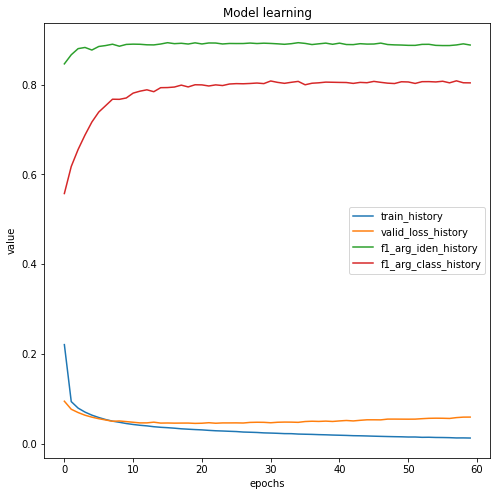

In [38]:
display_history(history)

# Reformatting the matrix output

In [46]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_embtest import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer = True,
    saves_path_folder = test_name,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
print_summary(final_model.model)

Net_aic_transformer_embtest(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

This first test uses a crafted matrix in order to compute the mean of subwords vectors:

In [48]:
from inspect import getsource
print(getsource(final_model.model.forward))

    def forward(
        self, 
        input_ids, 
        attention_mask, 
        matrix_subwords,
        formatted_word_ids,
        batch_sentence_predicates,
        batch_predicate_position,
        batch_pos_tags,

        token_type_ids = None,
    ):
        
        # ) Embedding (transformer)

        transformer_kwargs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

        if token_type_ids is None: # some transformer models don't have it
            transformer_kwargs['token_type_ids'] = token_type_ids

        n_transformer_hidden_states = 4

        transformer_outs = self.transformer_model(**transformer_kwargs)

        transformer_out = torch.stack( # transformer_out = (batch, sentence_len, 768)
            transformer_outs.hidden_states[-n_transformer_hidden_states:],
            dim=0).sum(dim=0)

        # # Matrix computation

        # matrix_ex_reshaped = torch.swapaxes(matrix_subwords,0,1)

        # res_prod =

In [49]:
history = {}

In [50]:
from stud.modelsTests.utils.Trainer_aic_transformer_embtest import Trainer_aic_transformer_embtest

trainer = Trainer_aic_transformer_embtest()

history = trainer.train(
    final_model, optimizer, dataloader_train_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'arg_iden_class_net_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.324830
# Validation loss => 0.173260 | f1-score: arg_iden = 0.246826 arg_class = 0.195107 #
Epoch   1 => avg_loss: 0.149614
# Validation loss => 0.099617 | f1-score: arg_iden = 0.778779 arg_class = 0.539982 #
Epoch   2 => avg_loss: 0.102740
# Validation loss => 0.084274 | f1-score: arg_iden = 0.844768 arg_class = 0.594307 #
Epoch   3 => avg_loss: 0.087478
# Validation loss => 0.073713 | f1-score: arg_iden = 0.850208 arg_class = 0.635154 #
Epoch   4 => avg_loss: 0.079006
# Validation loss => 0.068071 | f1-score: arg_iden = 0.873059 arg_class = 0.667219 #
Epoch   5 => avg_loss: 0.072212
# Validation loss => 0.065487 | f1-score: arg_iden = 0.875579 arg_class = 0.687940 #
Epoch   6 => avg_loss: 0.066722
# Validation loss => 0.060419 | f1-score: arg_iden = 0.876628 arg_class = 0.713363 #
Epoch   7 => avg_loss: 0.061533
# Validation loss => 0.056436 | f1-score: arg_iden = 0.878729 arg_class = 0.730907 #
Epoch   8 => avg_loss: 0.057159
# Validation loss => 0.054697 | 

Traceback (most recent call last):
  File "/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1445/806783136.py", line 5, in <cell line: 5>
    history = trainer.train(
  File "/mnt/c/Users/Marco/Desktop/Magistrale/NLP/projects/2022_hw2/nlp2022-hw2/hw2/stud/modelsTests/notebooks/../../../stud/modelsTests/utils/Trainer.py", line 52, in train
    dict_out = self.compute_forward(final_model.model, sample, device, optimizer = optimizer) # override
  File "/mnt/c/Users/Marco/Desktop/Magistrale/NLP/projects/2022_hw2/nlp2022-hw2/hw2/stud/modelsTests/notebooks/../../../stud/modelsTests/utils/Trainer_aic_transformer_embtest.py", line 36, in compute_forward
    predictions = model.forward(
  File "/mnt/c/Users/Marco/Desktop/Magistrale/NLP/projects/2022_hw2/nlp2022-hw2/hw2/stud/modelsTests/notebooks/../../../stud/modelsTests/model_arg_iden_class_p

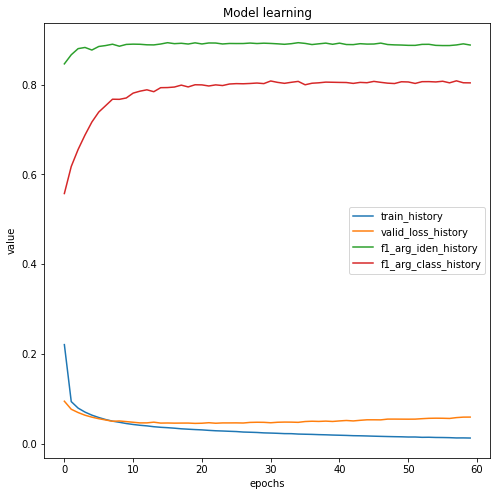

In [ ]:
display_history(history)

# OLD TESTS

In [156]:
matrix_ex = torch.as_tensor([
    [
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for [CLS]
        [0,1,0,0,0,0,0,0,0,0, 0, 0], # for This
        [0,0,1,1,0,0,0,0,0,0, 0, 0], # for transform (+ ##er) (notice here!)
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for ##er (notice here!, It's set to 0)
        [0,0,0,0,1,0,0,0,0,0, 0, 0], # for is
        [0,0,0,0,0,1,0,0,0,0, 0, 0], # for cool
        [0,0,0,0,0,0,1,0,0,0, 0, 0], # for !
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for [SEP]
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for is (notice here!, It's set to 0)
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for [SEP]
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # padding...
        [0,0,0,0,0,0,0,0,0,0, 0, 0]  # ...padding
    ],
    [
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for [CLS]
        [0,1,0,0,0,0,0,0,0,0, 0, 0], # for This
        [0,0,1,1,0,0,0,0,0,0, 0, 0], # for transform (+ ##er) (notice here!)
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for ##er (notice here!, It's set to 0)
        [0,0,0,0,1,0,0,0,0,0, 0, 0], # for is
        [0,0,0,0,0,1,0,0,0,0, 0, 0], # for cool
        [0,0,0,0,0,0,1,0,0,0, 0, 0], # for !
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for [SEP]
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for is (notice here!, It's set to 0)
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # for [SEP]
        [0,0,0,0,0,0,0,0,0,0, 0, 0], # padding...
        [0,0,0,0,0,0,0,0,0,0, 0, 0]  # ...padding
    ],
])

out_model_ex = torch.as_tensor([
    [ [-1,-1,-1], [1,1,1], [2,2,2], [2,2,0], [3,3,3], [4,4,4], [5,5,5], [-1,-1,-1], [3,3,3], [-1,-1,-1], [-1,-1,-1], [-1,-1,-1] ],
    [ [-1,-1,-1], [1,1,1], [2,2,2], [2,2,0], [3,3,3], [4,4,4], [5,5,5], [-1,-1,-1], [3,3,3], [-1,-1,-1], [-1,-1,-1], [-1,-1,-1] ],
])

in_word_ids = torch.as_tensor([
    [-1,0,1,1,2,3,4,-1,-1,-1,-1,-1],
    [-1,0,1,1,2,3,4,-1,-1,-1,-1,-1],
])

In [160]:
matrix_ex.shape, out_model_ex.shape

(torch.Size([2, 12, 12]), torch.Size([2, 12, 3]))

In [158]:
matrix_ex_reshaped = torch.swapaxes(matrix_ex,0,1)

res_prod = (matrix_ex_reshaped[:,:,:,None] * out_model_ex[None,:,:,:])
res_prod = torch.swapaxes(res_prod,0,1)

matrix_ex_mask = matrix_ex.count_nonzero(-1)
matrix_ex_mask = torch.where(matrix_ex_mask>0,matrix_ex_mask,1)

matrix_computed = (res_prod.sum(dim=-2) / matrix_ex_mask[:,:,None])
matrix_computed

tensor([[[0., 0., 0.],
         [1., 1., 1.],
         [2., 2., 1.],
         [0., 0., 0.],
         [3., 3., 3.],
         [4., 4., 4.],
         [5., 5., 5.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 1., 1.],
         [2., 2., 1.],
         [0., 0., 0.],
         [3., 3., 3.],
         [4., 4., 4.],
         [5., 5., 5.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [159]:
matrix_computed.shape, in_word_ids.shape

(torch.Size([2, 12, 3]), torch.Size([2, 12]))

In [166]:
matrix_computed_formatted = torch.zeros(matrix_computed.shape)
for b, batch in enumerate(matrix_computed):
    previous_id = None
    for i, word_vector in enumerate(batch):
        pos = in_word_ids[b][i]
        if pos != -1 and pos != previous_id:
            matrix_computed_formatted[b][pos] = matrix_computed[b][i]
        previous_id = pos

In [167]:
matrix_computed_formatted

tensor([[[1., 1., 1.],
         [2., 2., 1.],
         [3., 3., 3.],
         [4., 4., 4.],
         [5., 5., 5.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 1., 1.],
         [2., 2., 1.],
         [3., 3., 3.],
         [4., 4., 4.],
         [5., 5., 5.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [42]:
from torch import nn

ee = nn.Embedding(3,10,0)
lll = nn.Linear(3,10,False)

In [65]:
ee( torch.as_tensor([1,2,2]) )

tensor([[-0.9684, -0.0348, -2.0594, -1.8089, -0.5899, -0.6094, -0.2437,  1.6009,
         -1.1884,  1.4482],
        [ 1.4010,  0.1630,  0.4457,  1.0707,  0.3655,  0.8652,  1.7827,  0.6841,
          0.2043, -0.2954],
        [ 1.4010,  0.1630,  0.4457,  1.0707,  0.3655,  0.8652,  1.7827,  0.6841,
          0.2043, -0.2954]], grad_fn=<EmbeddingBackward>)

In [66]:
lll( torch.as_tensor([1.,1.,1.]) )

tensor([-0.7318,  0.1912, -0.2675, -0.0388, -0.2304, -0.1599, -0.2847,  0.4010,
        -0.0373,  0.2144], grad_fn=<SqueezeBackward3>)